In [0]:
import torch
import torch.nn as nn
from torch.nn import init
from torchvision import models
import torch.nn.functional as F
import random
random.seed(350)
import numpy as np
from torchvision import transforms, utils
import matplotlib.pyplot as plt
% matplotlib inline
import torch.optim as optim
from google.colab import output, drive
from torch.autograd import Variable
from PIL import Image
import os
import csv
# output.clear()
 
# Make train results reproducible
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
 
use_cuda = torch.cuda.is_available()
device_use = torch.device("cuda" if use_cuda else "cpu")
print(device_use, ' used...')
!nvidia-smi

cuda  used...
Fri May 15 17:14:08 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    25W /  70W |    923MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Mem

# Connect to drive in order to download new files in it

In [0]:
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/
!mkdir BACR_Project
%cd BACR_Project
output.clear()
!pwd
!mkdir Dataset
!mkdir VAE

/content/drive/My Drive/BACR_Project


# Convolutional Variational AutoEncoder

In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

class ConvVAE(nn.Module):
    def __init__(self, image_channels = 3, hidden_dim = 1024, latent_dim=32, kl_tolerance = 0.5):

        '''
        Args:
            image_channels: A integer indicating the number of channels in image.
            hidden_dim: A integer indicating the size of hidden dimension.
            latent_dim: A integer indicating the latent size.
        '''
        super(ConvVAE, self).__init__()

        self.latent_dim = latent_dim
        self.kl_tolerance = kl_tolerance

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=image_channels, out_channels=32, kernel_size=4, stride = 2),
            nn.ReLU(True),

            nn.Conv2d(in_channels=32,out_channels= 64, kernel_size = 4, stride = 2),
            nn.ReLU(True),

            nn.Conv2d(in_channels=64,out_channels= 128, kernel_size = 4, stride = 2),
            nn.ReLU(True),

            nn.Conv2d(in_channels=128,out_channels= 256, kernel_size = 4, stride = 2),
            nn.ReLU(True),
            Flatten()
        )

        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(in_channels=hidden_dim,out_channels= 128, kernel_size = 5, stride = 2),
            nn.ReLU(True),
           
            nn.ConvTranspose2d(in_channels=128,out_channels= 64, kernel_size = 5, stride = 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels=64,out_channels= 32, kernel_size = 6, stride = 2),
            nn.ReLU(True),
           
            nn.ConvTranspose2d(in_channels=32,out_channels= image_channels, kernel_size = 6, stride = 2),
            nn.Sigmoid()
        )

        self.fc1 = nn.Linear(hidden_dim, latent_dim)

        self.fc3 = nn.Linear(latent_dim, hidden_dim)

    def encode(self, x):
        conv = self.encoder(x)
        h1 = self.fc1(conv)
        return h1, h1

    def decode(self, z):
        
        deconv_input = self.fc3(z)
        deconv_input = deconv_input.view(-1,1024,1,1)
        return self.decoder(deconv_input)

    def reparametrize(self, mu, logvar):
        sigma = logvar.exp()
        eps = torch.randn_like(sigma)
        return  eps.mul(sigma).add_(mu)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        decoded = self.decode(z)
        return decoded, mu, logvar, z  

    def architecture(self):
        return ConvVAE().to(self.used_device)

    def loss(self, decoded, x, mu, logsigma):
        # BCE =  F.binary_cross_entropy(decoded, x, reduction='sum')
        BCE = torch.sum(torch.square((decoded-x)))
        reconstruct_loss = BCE
        KLD = -0.5 * torch.sum((1 + 2*logsigma - mu**2 - (2*logsigma).exp()))
        KLD = torch.max(KLD, torch.Tensor([self.kl_tolerance * self.latent_dim]).cuda())
        KLD = torch.mean(KLD)
        regularization_loss = KLD
        loss = reconstruct_loss + regularization_loss
        return loss

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [0]:
read_and_resize = transforms.Compose([            
     transforms.Resize(64),                    
     transforms.ToTensor(),   
    #  transforms.Normalize(mean=(0.5,), std=(0.5,))
    ]) # transofrmation for images in order to allow them be input for our NN model.

### Download train data

In [0]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1U58xFkQ8nNj97gXaUGR-7xj8lvwBg7RY' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1U58xFkQ8nNj97gXaUGR-7xj8lvwBg7RY" -O train_set.tar.xz && rm -rf /tmp/cookies.txt
!tar -xf train_set.tar.xz
output.clear()

### Introduce function that creates the csv files by given dataset, dividing it into training and testing ones

In [0]:
def create_csv(path = 'snapshots', fraction = 0.9, training_csv = 'Dataset/training_set_VAE.csv', testing_csv = 'Dataset/testing_set_VAE.csv'):
  images = os.listdir(path) # find all images in the folder

  images_path_list = []

  for image in images:
      image_path = os.path.join(path, image)
      images_path_list.append(image_path)
  
  # create pandas dataftame
  df = pd.DataFrame(images_path_list)

  # Split the dataframe into two (test and train datasets)
  msk = np.random.rand(len(df)) < fraction 

  train = df[msk]
  train.to_csv(training_csv, index=False, header=False)

  test = df[~msk]
  test.to_csv(testing_csv, index=False, header=False)

  return training_csv, testing_csv  

### Let's create dataloader for training

In [0]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader

class Dataset(Dataset):
    """Training dataset. Triple creator"""
    # Idea of creating datasets here:
    # https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

    def __init__(self,csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
              
        self.csv = pd.read_csv(csv_file, header = None)
        self.transform = transform

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
          idx = idx.tolist()

        self.img = self.csv.iloc[idx, 0] # file name for img
        self.img =Про Image.open(self.img)

        if self.transform:     
            self.img = self.transform(self.img)
        return self.img         




In [0]:
training_csv, testing_csv = create_csv()
train_dataset = Dataset(training_csv, transform = None)
test_dataset = Dataset(testing_csv, transform = None)

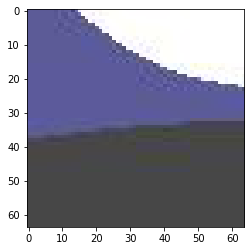

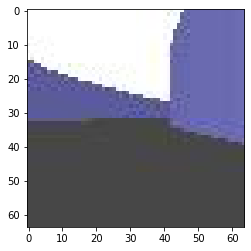

In [0]:
trans_To_Pil = transforms.ToPILImage()
input_img_train = train_dataset[0]
input_img_test = test_dataset[0]
plt.imshow(input_img_train)
plt.show()
plt.imshow(input_img_test)
plt.show()

### Train CVAE

In [0]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, sample in enumerate(train_loader):
        # move data to the GPU
        sample = sample.to(device)

        # set the gradients to zero before starting to do backpropragation
        optimizer.zero_grad()

        # pass the sample through the model
        decoded, mu, logvar, z = model(sample)

        # calculate the loss function
        # loss = loss_function(decoded, sample, mu, logvar)
        loss = model.loss(decoded, sample, mu, logvar)
        train_loss += loss.item()
        
        # backpropragate the loss
        loss.backward()
        optimizer.step()
        
        to_print = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(sample), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(sample))
        
        if batch_idx % log_interval == 0:
            print(to_print)

    train_loss /= len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss))
    
    return train_loss, to_print

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for sample in test_loader:
            # move data to the GPU
            sample = sample.to(device)

            # pass the sample through the model
            decoded, mu, logvar,z = model(sample)

            # calculate the loss function
            loss = model.loss(decoded, sample, mu, logvar)
            test_loss += loss.item()
    test_loss = test_loss/len(test_loader.dataset)
    to_print = '====> Test set loss: {:.4f}'.format(test_loss)
    print(to_print)

    return test_loss, to_print

In [0]:
# Set the transformations
transform_train = transforms.Compose([
                                      transforms.Resize(64),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor()
                                      ])

transform_test = transforms.Compose([
                                     transforms.Resize(64),
                                     transforms.ToTensor()
                                     ])

# Initialize the datasets
train_dataset = Dataset(training_csv, transform=transform_train)
test_dataset = Dataset(testing_csv, transform=transform_test)

# Create the dataloader object
train_dataset_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8)
test_dataset_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=8)

# Initialize the loss function
# loss_function = LossVAE()

model = ConvVAE().to(device_use)

In [0]:
!pwd

/content/drive/My Drive/BACR_Project


In [0]:
epochs = 2000
lr = 1e-3
log_interval = 100 # print the results every 'log_interval' batches

optimizer = optim.Adam(model.parameters(), lr=lr)

train_loss_list = []
test_loss_list = []

for epoch in range(1, epochs + 1):
    train_loss, to_print_train = train(model,device_use, train_dataset_loader, optimizer, epoch)
    test_loss,to_print_test = test(model, device_use, test_dataset_loader)

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    if epoch % 50 == 0:
      torch.save(model.state_dict(), "VAE/CVAE"+str(epoch)+".pt")

Train Epoch: 1 [0/9381 (0%)]	Loss: 880.456421
Train Epoch: 1 [6400/9381 (68%)]	Loss: 158.695648
====> Epoch: 1 Average loss: 279.5304
====> Test set loss: 133.0943
Train Epoch: 2 [0/9381 (0%)]	Loss: 137.400757
Train Epoch: 2 [6400/9381 (68%)]	Loss: 128.118042
====> Epoch: 2 Average loss: 120.3935
====> Test set loss: 108.9403
Train Epoch: 3 [0/9381 (0%)]	Loss: 107.147079
Train Epoch: 3 [6400/9381 (68%)]	Loss: 105.685669
====> Epoch: 3 Average loss: 104.5260
====> Test set loss: 104.8367
Train Epoch: 4 [0/9381 (0%)]	Loss: 105.191429
Train Epoch: 4 [6400/9381 (68%)]	Loss: 90.644814
====> Epoch: 4 Average loss: 96.2095
====> Test set loss: 93.6096
Train Epoch: 5 [0/9381 (0%)]	Loss: 98.191269
Train Epoch: 5 [6400/9381 (68%)]	Loss: 87.572601
====> Epoch: 5 Average loss: 90.3782
====> Test set loss: 86.7860
Train Epoch: 6 [0/9381 (0%)]	Loss: 83.918495
Train Epoch: 6 [6400/9381 (68%)]	Loss: 85.937080
====> Epoch: 6 Average loss: 86.3986
====> Test set loss: 83.1309
Train Epoch: 7 [0/9381 (0%)

KeyboardInterrupt: ignored

In [0]:
plt.plot(train_loss_list,'b', linewidth=2.0)
plt.plot(test_loss_list,'r', linewidth=2.0)
plt.grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
plt.grid(True)
plt.xlim([0, epochs])
plt.ylabel(r'Loss')
plt.xlabel(r'Epoch')
plt.legend([r'Average train loss', r'Average test loss'])
plt.show()

In [0]:
model_file = 'VAE/CVAE500.pt'
CVAE_learned = ConvVAE().to(device_use)
CVAE_learned.load_state_dict(torch.load(model_file))

<All keys matched successfully>

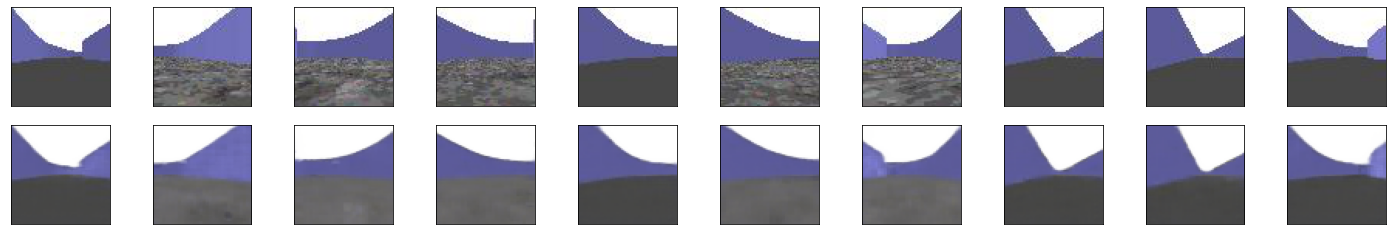

In [0]:

# obtain one batch of test images
dataiter = iter(test_dataset_loader)
images= dataiter.next()

# get sample outputs
outputs, mu, logvar,z = CVAE_learned(images.cuda())
# use detach when it's an output that requires_grad
output = outputs.cpu()
# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
  for img, ax in zip(images, row):
      img = trans_To_Pil(img)
      ax.imshow(np.squeeze(img))
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

### Let's give as input some noise

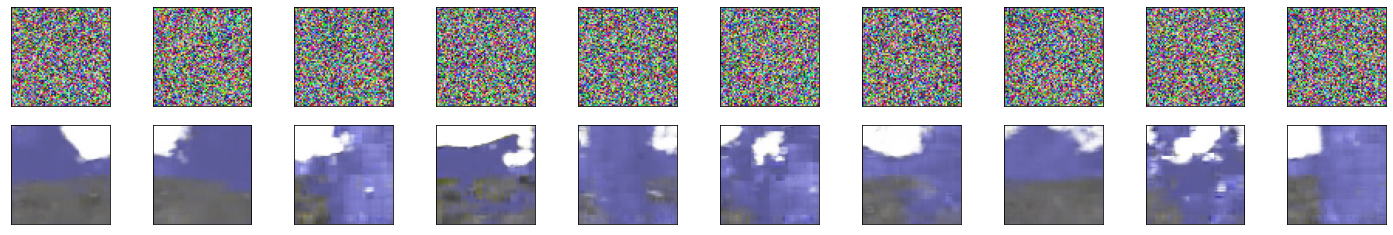

In [0]:
# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

sample = Variable(torch.randn(10,3,64,64))
outputs, mu, logvar, z = CVAE_learned(sample.cuda())

# input images on top row, reconstructions on bottom
for images, row in zip([sample, outputs.cpu()], axes):
  for img, ax in zip(images, row):
      img = trans_To_Pil(img)
      ax.imshow(np.squeeze(img))
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
plt.show()  